# Data Download

In [ ]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '79c05eac-dadd-4fc9-be16-acdb5c068bb9'
resource_group = 'skh-ml-rg003'
workspace_name = 'SKH-ML-WS003'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='re_data_1')
dataset.download(target_path='.', overwrite=False)

# Libaray import

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.semi_supervised import LabelSpreading
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [73]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  ca-certificates-java cmake-data cuda-command-line-tools-11-3
  cuda-compiler-11-3 cuda-cudart-11-3 cuda-cudart-dev-11-3 cuda-cuobjdump-11-3
  cuda-cupti-11-3 cuda-cupti-dev-11-3 cuda-cuxxfilt-11-3
  cuda-documentation-11-3 cuda-driver-dev-11-3 cuda-gdb-11-3
  cuda-libraries-11-3 cuda-libraries-dev-11-3 cuda-memcheck-11-3
  cuda-nsight-11-3 cuda-nsight-compute-11-3 cuda-nsight-systems-11-3
  cuda-nvcc-11-3 cuda-nvdisasm-11-3 cuda-nvml-dev-11-3 cuda-nvprof-11-3
  cuda-nvprune-11-3 cuda-nvrtc-11-3 cuda-nvrtc-dev-11-3 cuda-nvtx-11-3
  cuda-nvvp-11-3 cuda-samples-11-3 cuda-sanitizer-11-3 cuda-thrust-11-3
  cuda-toolkit-11-3 cuda-toolkit-11-3-config-common
  cuda-toolkit-11-config-common cuda-toolkit-config-common cuda-tools-11-3
  cuda-visual-tools-11-3 default

In [74]:
plt.rc('font', family='NanumBarunGothic')

plt.style.use("seaborn")
sns.set(font="NanumBarunGothic", 
rc={"axes.unicode_minus":False}, style='white')
%config InlineBackend.figure_format = 'retina'

# Data Load

1980년부터 2018년까지 평균 기온, 자외선, 이산화 탄소량 등이 기록된 데이터이다.

In [137]:
climate_df = pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/skh-ml-vm003/code/Users/SKH-ML-GRP003-USR001/생물다양성 변수_수정.csv",
            encoding = "euc-kr")

In [138]:
# 데이터의 첫 5행
climate_df.head()

,관측일자,coal,Natural gas,Nuclear,Hydro,"Wind,solar,etc",Biofuels,Oil,관측개체수,평균기온,일최대 자외선 B(W/m2 ) __ B(W/m2 ),평균풍속(m/s),평균 이산화탄소(CO2) 배경대기농도(ppm),평균 지표오존(O₃) 농도(ppb),평균 이산화황(SO₂) 농도(ppb),평균 질소산화물(NOｘ) 농도(ppb),평균 일산화탄소(CO) 농도(ppb),합계 강수량(mm)
0,1981.7.21,850201.60000,0.00000,28847.45000,2290.00000,1260.00000,11221.00000,1041137.50000,18,25.70000,nan,3.00000,nan,nan,nan,nan,nan,nan
1,1981.7.22,nan,nan,nan,nan,nan,nan,nan,21,26.50000,nan,2.70000,nan,nan,nan,nan,nan,nan
2,1981.7.24,nan,nan,nan,nan,nan,nan,nan,13,27.90000,nan,2.10000,nan,nan,nan,nan,nan,nan
3,1981.9.30,nan,nan,nan,nan,nan,nan,nan,17,17.70000,nan,1.70000,nan,nan,nan,nan,nan,nan
4,1981.10.1,nan,nan,nan,nan,nan,nan,nan,59,17.70000,nan,2.20000,nan,nan,nan,nan,nan,nan


In [139]:
# 데이터의 요약통계량량
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   관측일자                          1706 non-null   object 
 1   coal                          17 non-null     float64
 2   Natural gas                   17 non-null     float64
 3   Nuclear                       17 non-null     float64
 4   Hydro                         17 non-null     float64
 5   Wind,solar,etc                17 non-null     float64
 6   Biofuels                      17 non-null     float64
 7   Oil                           17 non-null     float64
 8   관측개체수                         1706 non-null   int64  
 9   평균기온                          1706 non-null   float64
 10  일최대 자외선 B(W/m2 ) __ B(W/m2 )  1159 non-null   float64
 11  평균풍속(m/s)                     1706 non-null   float64
 12  평균 이산화탄소(CO2) 배경대기농도(ppm)     1161 non-null   float64
 13  평균 

In [140]:
# 데이터의 기술통계량량
climate_df.describe()

,coal,Natural gas,Nuclear,Hydro,"Wind,solar,etc",Biofuels,Oil,관측개체수,평균기온,일최대 자외선 B(W/m2 ) __ B(W/m2 ),평균풍속(m/s),평균 이산화탄소(CO2) 배경대기농도(ppm),평균 지표오존(O₃) 농도(ppb),평균 이산화황(SO₂) 농도(ppb),평균 질소산화물(NOｘ) 농도(ppb),평균 일산화탄소(CO) 농도(ppb),합계 강수량(mm)
count,17.00000,17.00000,17.00000,17.00000,17.00000,17.00000,17.00000,1706.00000,1706.00000,1159.00000,1706.00000,1161.00000,1146.00000,1146.00000,1146.00000,1146.00000,1346.00000
mean,1932342.56471,851279.00000,1031203.67353,11287.82353,17305.52941,116777.11765,3615503.32353,163.41032,16.15246,0.15213,2.24862,409.30233,44.79756,1.69974,6.01728,255.88874,14.42689
std,1126501.77513,773654.51677,529200.41767,4332.53503,25209.95525,118482.49247,1009913.26984,216.81579,9.69139,0.05781,0.83508,9.45069,14.83383,1.26866,3.52777,120.12151,17.77562
min,850201.60000,0.00000,28847.45000,2290.00000,420.00000,11221.00000,1041137.50000,1.00000,-9.70000,0.01300,0.10000,368.43000,3.40000,0.10000,0.10000,46.80000,0.70000
25%,1062752.00000,216680.00000,634233.00000,9907.00000,716.00000,30591.00000,3267696.00000,25.00000,9.12500,0.11000,1.70000,403.86000,34.40000,0.80000,3.50000,181.40000,2.50000
50%,1332977.00000,522995.00000,840938.00000,10152.00000,1803.00000,40582.00000,3972553.00000,76.50000,18.60000,0.15600,2.10000,410.47000,45.20000,1.40000,5.40000,241.20000,8.00000
75%,3372296.00000,1729700.00000,1591742.00000,12550.00000,31700.00000,246107.00000,4372399.00000,215.75000,23.80000,0.19500,2.70000,415.85000,54.30000,2.20000,7.80000,308.00000,22.00000
max,3458248.00000,2046086.00000,1797404.00000,22900.00000,77628.00000,301039.00000,4620328.00000,2118.00000,33.60000,0.31200,6.50000,434.60000,100.80000,12.50000,38.20000,1042.00000,131.00000


# Prepropessing

In [76]:
# 사용하지 않을 특성 제거
climate_df.drop(['coal', 'Natural gas', 'Nuclear', 'Hydro', 'Wind,solar,etc',
       'Biofuels', 'Oil', '관측개체수'], axis = 1, inplace= True)

In [77]:
# object type인 날짜를 datetime type으로 변환
climate_df["관측일자"] = pd.to_datetime(climate_df["관측일자"])

## 결측치 처리

In [78]:
mean_li = list() # 데이터로 월별 평균을 구하여 리스트에 저장

for i in range(1, 13, 1):
    # 1월부터 12월까지 반복
    month_dict = dict()
    query_month = i
    filtered3 = climate_df.query('관측일자.dt.month == @query_month')
    # query구문을 통하여 월별로 필터링
    for col in filtered3:
        # 각 컬럼별 평균을 구해 월별 딕셔너리에 저장
        month_dict[col] = filtered3[col].mean()
    # 각 월별 딕셔너리를 평균리스트에 추가
    mean_li.append(month_dict)

In [79]:
# 새로운 데이터 프레임을 추가
res = pd.DataFrame()
for i in range(1, 13, 1):
    # 1월부터 12월까지 반복
    query_month = i
    filtered = climate_df.query('관측일자.dt.month == @query_month')
    for col in filtered:
        # 결측치를 평균 값으로 대치
        filtered[col].fillna(mean_li[i-1][col], inplace = True)
    # 새로운 데이터 프레임에 병합하면서 모든 데이터를 재구성
    res = pd.concat([res, filtered])

In [80]:
# 관측일자가 기록되어 있지 않은 결측치 제거
res.dropna(inplace = True)
# 날짜별로 재정렬렬
res = res.sort_values("관측일자")

## Labeling

1990년 이전 데이터는 0(철새인 환경), 2017년 이후 데이터는 1(텃새화가 된 환경)으로 라벨링을 해준다.

In [81]:
# 라벨링을 할 칼럼을 Na 값으로 초기화화
res["label"] = np.NaN
# 90년대 이전은 0, 17년도 이후는 1로 부여
series_1 = res[res["관측일자"] <= "1990"]["label"].apply(lambda x: 0)
series_2 = res[res["관측일자"] >= "2017"]["label"].apply(lambda x: 1)
label = pd.concat([series_1, series_2])
res["label"] = label

In [82]:
# 데이터를 라벨링된 데이터와 라벨링 안된 데이터로 분리
labeled_df = res[-res["label"].isna()]
unlabeled_df = res[res["label"].isna()]

## LabelSpreading

라벨링이 안된 데이터프레임에 라벨링을 해주기 위해서 LabelSpreading 모델을 생성하고 라벨링을 해준다.

In [83]:
X = labeled_df.drop(["관측일자","label"], axis = 1)
Y = labeled_df["label"]

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify = Y,
                                                    random_state = 29,
                                                    test_size = 0.2)

In [85]:
# LabelSpreading의 파라미터
params = {"kernel" : ["knn", "rbf"],
          "gamma" : np.arange(0, 1, 0.1),
          "n_neighbors" : [1, 3, 5, 7, 9],
          }

In [86]:
# GridSearch를 사용하여 LabelSpreading의 최적의 파라미터를 찾음
gr_label = GridSearchCV(LabelSpreading(), params, n_jobs = -1)
gr_label.fit(x_train, y_train)

GridSearchCV(estimator=LabelSpreading(), n_jobs=-1,
             param_grid={'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'kernel': ['knn', 'rbf'],
                         'n_neighbors': [1, 3, 5, 7, 9]})

만든 모델의 분류 성능을 평가한다.

In [87]:
# x_test 예측
test_pred = gr_label.predict(x_test)
# 실제 데이터와 비교를 위한 데이터프레임 생성
test = pd.DataFrame({"real" : y_test,
            "pred" : test_pred})

# ROC AUC 점수
print(f"roc score : {roc_auc_score(y_test, test_pred)}")
# 실제 데이터와 예측 데이터가 다른 행 출력
test[test["real"] - test["pred"] != 0]

roc score : 0.9275990099009901


,real,pred
1555,1.00000,0.00000
26,0.00000,1.00000
1480,1.00000,0.00000


roc score가 92.76%이고 실제 데이터와 차이도 3개 정도인 걸로 보아 분류가 제대로 되었음을 확인할 수 있다.

In [88]:
# 예측에 사용할 데이터프레임
pred_df = unlabeled_df.drop(["관측일자", "label"], axis = 1)
# 레이블 예측
pred_label = gr_label.predict(pred_df)
unlabeled_df["label"] = pred_label
# 라벨별 개수 출력
unlabeled_df["label"].value_counts()

1.00000    802
0.00000    274
Name: label, dtype: int64

In [89]:
# 라벨링된 데이터와 LabelSpreading을 통하여 라벨링을 해준 데이터를 병합
res_df = pd.concat([labeled_df, unlabeled_df])
# 모든 데이터의 라벨별 개수 출력
res_df["label"].value_counts()

1.00000    1303
0.00000     315
Name: label, dtype: int64

0과 1로 라벨링된 데이터 개수의 불균형을 확인할 수 있다.

# Modeling

## train_test_split

In [90]:
X = res_df.drop(["관측일자", "label"], axis = 1)
Y = res_df["label"]

In [91]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify = Y, random_state = 29, test_size = 0.2)

## Oversampling

종속 변수가 불균형한 분포를 보이므로 낮은 비율 클래스의 데이터 수를 늘리는 오버샘플링을 한다.

In [92]:
y_train.value_counts()

1.00000    1042
0.00000     252
Name: label, dtype: int64

현재 레이블이 1인 데이터는 1,042개, 0인 데이터는 252개로 오버샘플링을 통하여 불균형한 라벨 간의 개수를 맞춰준다.

낮은 비율 클래스 데이터의 최근접 이웃을 이용하여 새로운 데이터를 생성하는 SMOTE(Synthetic Minority Over-sampling Technique)를 이용한다.

In [93]:
smote = SMOTE(random_state = 29)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

In [94]:
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (1294, 9) (1294,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (2084, 9) (2084,)
SMOTE 적용 후 값의 분포 :
 0.00000    1042
1.00000    1042
Name: label, dtype: int64


## 신경망 모형

모델이 더 효과적으로 학습할 수 있도록 특성 스케일링을 하였으며 여기서는 표준화를 사용하였다.

In [95]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)

테스트 데이터와 검증 데이터로 나눈다.

In [96]:
scaled_train, scaled_val, y_train, y_val = train_test_split(scaled_train, y_train, stratify = y_train,
                                                            random_state = 29, test_size = 0.2)

### 모델 1
- 순서대로 연결된 층을 일렬로 쌓아서 구성하는 Sequential 모델을 생성했다.
- 뉴런 개수가 128, 64, 16, 4 그리고 1개인 층을 만들어 모델에 추가했다.
- 활성화 함수는 ReLU를 사용했다.
- 단, 마지막 뉴런이 1개인 출력층에서는 이진 분류 문제이므로 sigmoid 활성화 함수를 사용했다.

In [231]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = (9,)))
model.add(keras.layers.Dense(128, activation = "relu"))
model.add(keras.layers.Dense(64, activation = "relu"))
model.add(keras.layers.Dense(16, activation = "relu"))
model.add(keras.layers.Dense(4, activation = "relu"))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

케라스의 콜백기능을 사용하여 모델의 체크포인트를 저장해주고, 조기종료를 구성하여서 과대적합을 방지했다.

In [232]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-model.h5",
                                               save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2,
                                                 restore_best_weights = True)

# 이 셋 중 맘에 드는 거 하나 골라서 사용해주세요!

옵티마이저는 Adam을 사용하였으며, 이진 분류 문제이므로 손실함수는 binary_crossentropy를 사용하였으며, 평가지표는 accuracy를 사용하였다.

In [233]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss = "binary_crossentropy", metrics= "accuracy")

In [234]:
# 모델 학습
history = model.fit(scaled_train, y_train, epochs = 200,
                   validation_data = (scaled_val, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/200
33/33 [==============================] - 0s 6ms/step - loss: 0.5044 - accuracy: 0.7903 - val_loss: 0.3986 - val_accuracy: 0.8069
Epoch 2/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3562 - accuracy: 0.8300 - val_loss: 0.3363 - val_accuracy: 0.8417
Epoch 3/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8435 - val_loss: 0.2934 - val_accuracy: 0.8494
Epoch 4/200
33/33 [==============================] - 0s 3ms/step - loss: 0.2645 - accuracy: 0.8754 - val_loss: 0.2561 - val_accuracy: 0.8726
Epoch 5/200
33/33 [==============================] - 0s 3ms/step - loss: 0.2260 - accuracy: 0.9072 - val_loss: 0.2246 - val_accuracy: 0.8996
Epoch 6/200
33/33 [==============================] - 0s 3ms/step - loss: 0.1932 - accuracy: 0.9246 - val_loss: 0.19

train과 validation 각각의 loss와 accuracy를 시각화한 결과는 다음과 같다.

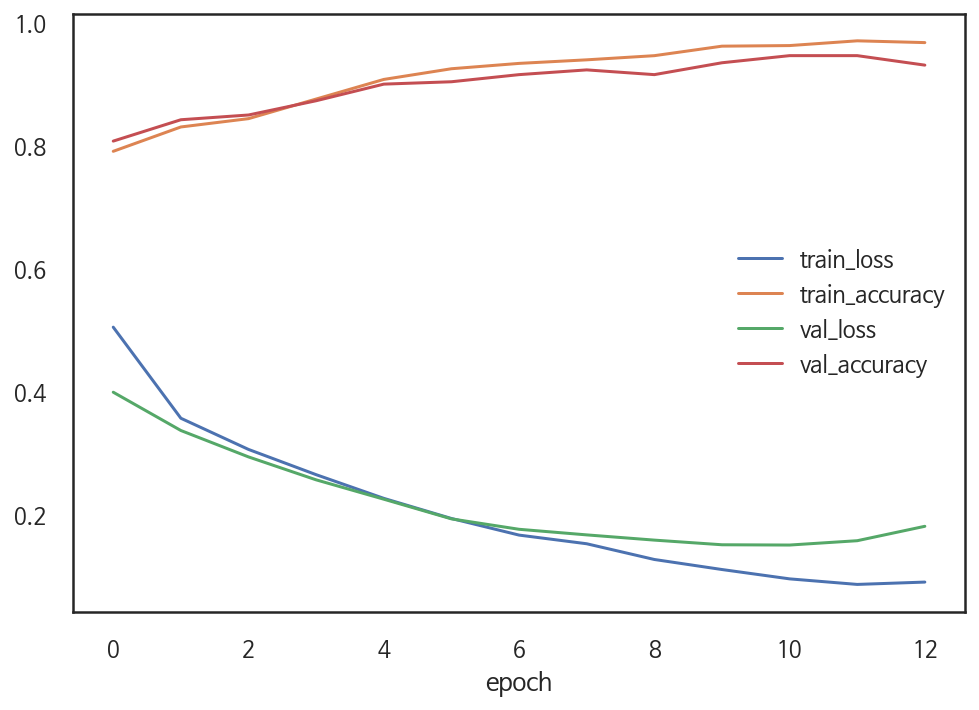

In [235]:
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_accuracy")

plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [236]:
# 몇 번째 에포크에서 중지되었는지 확인
print(early_stopping_cb.stopped_epoch)

12


In [237]:
model.evaluate(scaled_val, y_val)

9/9 [==============================] - 0s 521us/step - loss: 0.1500 - accuracy: 0.9459


[0.15003201365470886, 0.9459459185600281]

12번째 에포크에서 종료가 되었으며, accuracy는 94.59% 정도 나온 것으로 확인된다.

### 모델 2
- 다음은 모델 1과 같은 모델에서 모델의 성능 향상을 위해 처음 두 개의 밀집층 사이에 Dropout 층을 포함시켰다.

In [291]:
model_dr = keras.Sequential()
model_dr.add(keras.layers.Flatten(input_shape = (9,)))
model_dr.add(keras.layers.Dense(128, activation = "relu"))
model_dr.add(keras.layers.Dropout(0.45))
model_dr.add(keras.layers.Dense(64, activation = "relu"))
model_dr.add(keras.layers.Dropout(0.45))
model_dr.add(keras.layers.Dense(16, activation = "relu"))
model_dr.add(keras.layers.Dense(4, activation = "relu"))
model_dr.add(keras.layers.Dense(1, activation = "sigmoid"))

In [292]:
opt = keras.optimizers.Adam()
model_dr.compile(optimizer=opt, loss = "binary_crossentropy", metrics= "accuracy")

In [293]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-model_dr.h5",
                                               save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2,
                                                 restore_best_weights = True)

In [294]:
# 모델 학습
history_dr = model_dr.fit(scaled_train, y_train, epochs = 200,
                   validation_data = (scaled_val, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/200
33/33 [==============================] - 0s 6ms/step - loss: 0.5192 - accuracy: 0.7836 - val_loss: 0.4101 - val_accuracy: 0.8069
Epoch 2/200
33/33 [==============================] - 0s 3ms/step - loss: 0.4034 - accuracy: 0.8077 - val_loss: 0.3673 - val_accuracy: 0.8108
Epoch 3/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3736 - accuracy: 0.8203 - val_loss: 0.3455 - val_accuracy: 0.8417
Epoch 4/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3539 - accuracy: 0.8309 - val_loss: 0.3272 - val_accuracy: 0.8417
Epoch 5/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8473 - val_loss: 0.3078 - val_accuracy: 0.8494
Epoch 6/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3040 - accuracy: 0.8560 - val_loss: 0.28

train과 validation 각각의 loss와 accuracy를 시각화한 결과는 다음과 같다.

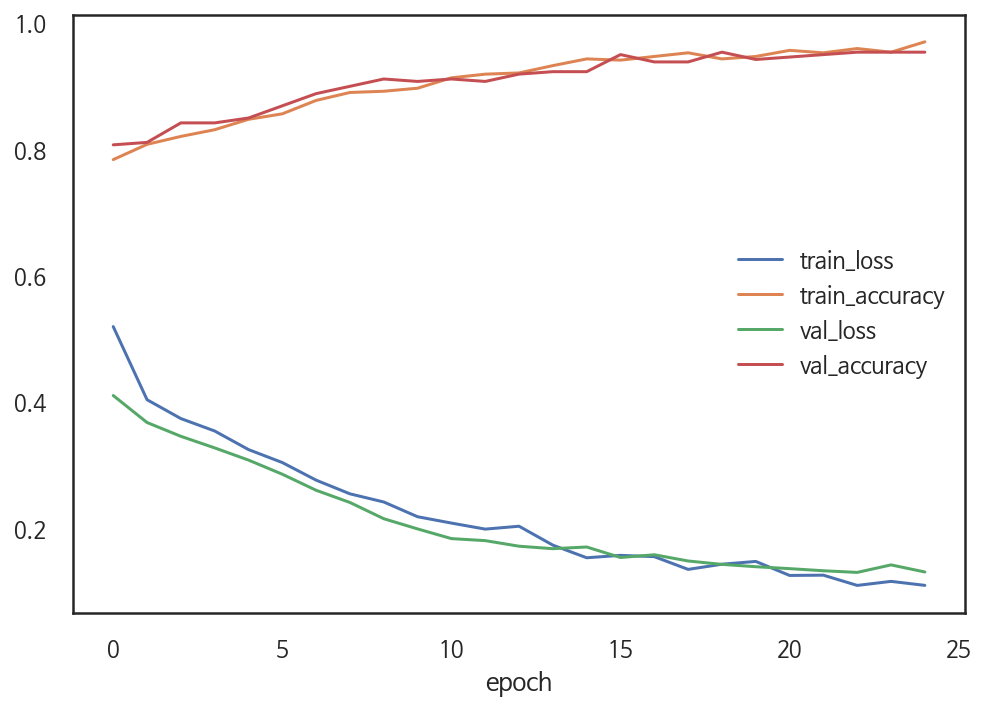

In [295]:
plt.figure()
plt.plot(history_dr.history["loss"], label = "train_loss")
plt.plot(history_dr.history["accuracy"], label = "train_accuracy")

plt.plot(history_dr.history["val_loss"], label = "val_loss")
plt.plot(history_dr.history["val_accuracy"], label = "val_accuracy")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [296]:
# 몇 번째 에포크에서 중지되었는지 확인
print(early_stopping_cb.stopped_epoch)

24


In [297]:
model_dr.evaluate(scaled_val, y_val)

9/9 [==============================] - 0s 542us/step - loss: 0.1300 - accuracy: 0.9537


[0.13001690804958344, 0.953667938709259]

모델 2의 결과, 에포크 24에서 학습이 중지됐고 약 95.37%의 정확도를 보임으로써 모델 1보다 Dropout을 추가한 해당 모델이 더 적절하다고 판단하였다. 추가로, test 데이터를 표준화한 후 평가한 결과 약 94.75%의 정확도를 보였다.

In [298]:
scaled_test = ss.transform(x_test)

In [299]:
model_dr.evaluate(scaled_test, y_test)

11/11 [==============================] - 0s 517us/step - loss: 0.2086 - accuracy: 0.9475


[0.20855948328971863, 0.9475308656692505]

## Randomforest
신경망 모형과 함께 비모수적 모형이며 추가로 특성 중요도를 확인할 수 있다. 또한, 결과 해석이 쉽다는 장점이 있는 RandomForest를 사용하여 이진 분류를 해보았다.

### 모델 3
- 트리계열 알고리즘은 하이퍼파라미터를 튜닝하지 않고 모델을 생성하면 오버피팅이 발생하므로, 이를 방지하고자 GridSearch로 하이퍼파라미터 튜닝을 동시에 진행하며 모델을 생성하였다.

In [305]:
params = { 'n_estimators' : [10, 100],
          "min_impurity_decrease" : np.arange(0.0001, 0.001, 0.0001),
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

gr = GridSearchCV(RandomForestClassifier(random_state = 29, n_jobs = -1), params, n_jobs = -1)
gr.fit(scaled_train, y_train)

print(f"best_param : {gr.best_params_}")
print(f"best_score : {gr.best_score_}")

best_param : {'max_depth': 8, 'min_impurity_decrease': 0.0002, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
best_score : 0.9555555555555555


In [306]:
# 최적의 파라미터로 모델 학습
rf_re = RandomForestClassifier(max_depth = 8 ,min_impurity_decrease = 0.0002 
                               ,min_samples_leaf = 8, min_samples_split = 20, n_estimators = 100,
                              n_jobs = -1, random_state = 29)

rf_re.fit(scaled_train, y_train)

RandomForestClassifier(max_depth=8, min_impurity_decrease=0.0002,
                       min_samples_leaf=8, min_samples_split=20, n_jobs=-1,
                       random_state=29)

In [307]:
# test data 예측
re_pred = rf_re.predict(scaled_test)

In [308]:
re_accuracy = accuracy_score(y_test, re_pred)
print(f"{re_accuracy:.5f}")

0.96605


In [117]:
print(classification_report(y_test, re_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        63
         1.0       0.97      0.99      0.98       261

    accuracy                           0.97       324
   macro avg       0.96      0.93      0.94       324
weighted avg       0.97      0.97      0.97       324



GridSearch로 하이퍼파라미터 튜닝을 한 RandomForest 모델 3의 결과 96.61%의 정확도를 보였다.

### 모델 4
- 앞서 모델 3에서 GridSearch로 찾은 범위로 RandomizedSearch를 이용해 하이퍼파라미터 튜닝을 했다.

In [300]:
params = { 'n_estimators' : randint(10, 100),
           'max_depth' : randint(10, 100),
           'min_samples_leaf' : randint(1, 20),
           'min_samples_split' : randint(2, 20),
            "min_impurity_decrease" : uniform(0.0001, 0.001)
            }

rs = RandomizedSearchCV(RandomForestClassifier(random_state=29), params, n_jobs = -1, random_state = 29)
rs.fit(scaled_train, y_train)
print(f"best_param : {rs.best_params_}")
print(f"best_score : {rs.best_score_}")

best_param : {'max_depth': 79, 'min_impurity_decrease': 0.0003419864247038851, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 12}
best_score : 0.9661835748792271


In [301]:
# 최적의 파라미터로 학습
rf_rd = RandomForestClassifier(max_depth = 79, min_impurity_decrease = 0.0003419864247038851,
                              min_samples_leaf = 1, min_samples_split = 6, n_estimators = 12,
                              n_jobs = -1, random_state = 29)

rf_rd.fit(scaled_train, y_train)

RandomForestClassifier(max_depth=79,
                       min_impurity_decrease=0.0003419864247038851,
                       min_samples_split=6, n_estimators=12, n_jobs=-1,
                       random_state=29)

In [302]:
rd_pred = rf_rd.predict(scaled_test)

In [303]:
rd_accuracy = accuracy_score(y_test, rd_pred)

print(f"{rd_accuracy:.5f}")

0.96605


In [304]:
print(classification_report(y_test, rd_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        63
         1.0       0.97      0.99      0.98       261

    accuracy                           0.97       324
   macro avg       0.96      0.93      0.94       324
weighted avg       0.97      0.97      0.97       324



RandomizedSearch로 하이퍼파라미터 튜닝을 한 학습 결과도 위 모델 3과 비슷하게 96.61%의 정확도를 갖는다.

In [309]:
# 실제와 예측을 담은 데이터프레임 생성성
res_df = pd.DataFrame({"real" : y_test,
            "re_pred" : re_pred,
            "rd_pred" : rd_pred})

In [310]:
# 예측에 실패한 데이터 출력력
res_df[res_df["real"] - res_df["re_pred"] != 0]

,real,re_pred,rd_pred
853,0.00000,1.00000,1.00000
26,0.00000,1.00000,1.00000
877,0.00000,1.00000,1.00000
500,1.00000,0.00000,1.00000
953,0.00000,1.00000,1.00000
506,1.00000,0.00000,1.00000
688,1.00000,0.00000,0.00000
843,0.00000,1.00000,1.00000
614,0.00000,1.00000,1.00000
1059,0.00000,1.00000,1.00000


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


실제 데이터와 예측 데이터를 비교했을 때, 예측에 11개 정도 실패했으며, GridSearch를 사용한 모델 3과 RandomizedSearch를 사용한 모델 4과의 정답 개수의 차이는 1 ~ 2개 정도로 정확도가 비슷한 모델임을 알 수 있다.

In [125]:
# 모델 3의 특성 중요도 상위 20개 추출
fea_importance = rf_re.feature_importances_
fea_importances = pd.Series(fea_importance, index = x_train.columns)
fea_20 = fea_importances.sort_values(ascending=False)[:20]

모델 3의 특성 중요도를 나타냈다.

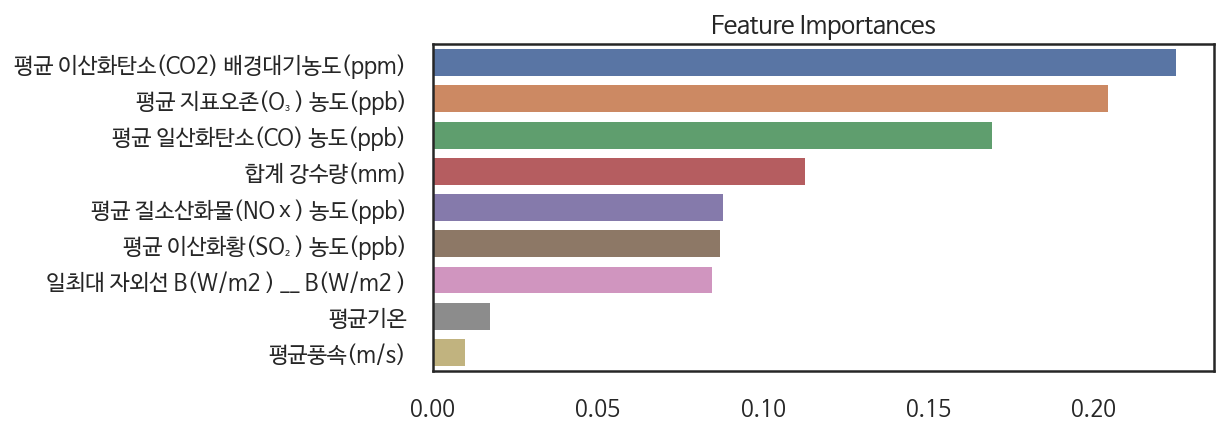

In [126]:
plt.figure(figsize=(7,3))
plt.title('Feature Importances')
sns.barplot(x=fea_20, y=fea_20.index)
plt.show()

RandomForest의 장점 중 하나는 특성 중요도를 눈으로 확인할 수 있다는 점인데 이를 확인해본 결과, 예측에 가장 중요하게 영향을 미친 특성은 평균 이산화탄소 배경대기 농도이며, 그다음으로 평균 지표오존, 평균 일산화탄소 순으로 영향을 미쳤다.

결론적으로, 기체 상의 대기 구성 성분 중 이산화탄소, 지표오존 그리고 일산화탄소의 농도를 낮춘다면 연쇄적으로 생물다양성 증진에 큰 기여를 할 수 있을 것으로 생각한다.

# Predict

## Data Download

In [127]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '79c05eac-dadd-4fc9-be16-acdb5c068bb9'
resource_group = 'skh-ml-rg003'
workspace_name = 'SKH-ML-WS003'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='pred_csv')
dataset.download(target_path='.', overwrite=False)

UserErrorException: UserErrorException:
	Message: File "/mnt/batch/tasks/shared/LS_root/mounts/clusters/skh-ml-vm003/code/Users/SKH-ML-GRP003-USR001/pred.csv" already exists. Set overwrite=True to overwrite it,                             or choose an empty target path.
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "File \"/mnt/batch/tasks/shared/LS_root/mounts/clusters/skh-ml-vm003/code/Users/SKH-ML-GRP003-USR001/pred.csv\" already exists. Set overwrite=True to overwrite it,                             or choose an empty target path."
    }
}

## Data Load

In [128]:
pred_test = pd.read_csv('/mnt/batch/tasks/shared/LS_root/mounts/clusters/skh-ml-vm003/code/Users/SKH-ML-GRP003-USR001/pred.csv')

## Preprocessing

In [129]:
# '관측일자' 특성을 제거
pred_test_dr = pred_test.drop(['관측일자'], axis = 1)

In [130]:
# 결측치를 0으로 채움
pred_test_dr = pred_test_dr.fillna(0)

In [131]:
# 특성 표준화
scaled_pred = ss.transform(pred_test_dr)

## Result

GridSearch로 하이퍼파라미터 튜닝을 한 RandomForest 모델 3을 이용해 최종적으로 예측을 한다.

In [311]:
# 모델 3으로 예측을 하고 이를 데이터프레임으로 생성
pred_label = pd.DataFrame(rf_re.predict(scaled_pred),
                        columns = ["label"])

In [312]:
# 실제 데이터와 최종 예측 label을 병합
result = pd.concat([pred_test, pred_label], axis = 1)

최종 예측 결과는 다음과 같다.

In [313]:
# 결과 출력
result

,관측일자,기온,일최대자외선,평균풍속,평균지표오존농도,평균이산화화황,평균질수산화물농도,평균일산화탄소농도,합계강수량,Unnamed: 9,label
0,2023.1.1,6.10000,0.12500,1.90000,420.25696,47.50000,0.70000,6.20000,266.50000,nan,1.00000
1,2024.1.1,-5.00000,0.03200,2.10000,418.00000,36.00000,1.00000,3.70000,226.86324,nan,1.00000
2,2025.1.1,-5.00000,0.03200,2.10000,415.00000,36.00000,1.00000,3.70000,213.06667,nan,1.00000
3,2026.1.1,-5.00000,0.03200,2.10000,412.00000,36.00000,1.00000,3.70000,205.85000,nan,1.00000
4,2027.1.1,-6.45000,0.04050,2.60000,410.00000,34.70000,0.85000,3.50000,198.63333,nan,1.00000
5,2028.1.1,-7.90000,0.04900,3.10000,407.00000,33.40000,0.70000,3.30000,184.20000,nan,1.00000
6,2029.1.1,-6.45000,0.04050,2.60000,402.00000,34.70000,0.85000,3.50000,198.63333,nan,1.00000
7,2030.1.1,-7.90000,0.04900,3.10000,397.00000,33.40000,0.70000,3.30000,184.20000,nan,1.00000
8,2031.1.1,-7.90000,0.04900,3.10000,394.00000,33.40000,0.70000,3.30000,184.20000,nan,1.00000
9,2032.1.1,-5.00000,0.03200,2.10000,389.00000,36.00000,1.00000,3.70000,260.25000,nan,1.00000


위 데이터는 2050년까지 탄소 중립을 실시했을 경우의 기온 및 기후 환경을 예측한 것이다. 이를 모델 3에 넣고 예측한 결과, 2033년에는 1(철새화가 된 환경)에서 0(텃새)일 수 있는 환경으로 되돌아온다. 그때의 분기점(2033년)인 평균 이산화탄소 농도가 @3.7, 오존 농도가 @??정도로 감소한다면 다시 이상적인 생태계로 돌아올 것으로 예측한다.

현재 우리나라는 2050년까지 탄소 중립 시행을 진행 중이며, 이에 따라 많은 기업이 탄소 중립을 위해 노력을 하고 있다. 지속해서 탄소 중립을 지킨다는 가정하에 위 분기점에서의 수치를 보이는 기후 환경이 형성되면 과거 기존의 생태계처럼 텃새였던 새가 철새가 되고, 개화 시기가 원래대로 돌아가는 등 생물다양성 증진에 크게 기여를 할 수 있을 것이다.